<a href="https://colab.research.google.com/github/Pawopiiieee/FloraAPI/blob/main/topic_analysis_roberta_gg-playstore_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic-classification-RoBERTa

In [1]:
!pip install simpletransformers==0.65.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.6/312.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
# load only a sub-selection of the categories (4 in our case)
data = pd.read_csv('google-playstore.csv', usecols=['App Name', 'Category'])

In [42]:
labels = ['Sports','Entertainment', 'Books & Reference']
filtered = data[data['Category'].isin(labels)]
filtered['Category'] = filtered['Category'].apply(lambda x: labels.index(x))
train_df = filtered.sample(2000)
print(train_df)

                                                App Name  Category
152819                                       Gonja Bible         2
93697                                               VMSA         1
57188                                     Kenpo training         0
70884   কুরবানির মাসআলা ~ কোরবানির নিয়ম, ইতিহাস ও দোয়া         2
93461                                mishras lover story         2
...                                                  ...       ...
74396                         Background Wallpapers Free         1
164523                              Quotes & Jokes Zilla         1
103207                                         Play Tube         1
99188                                  Holy Quran (Free)         2
126720                       Codice Deontologico Forense         2

[2000 rows x 2 columns]


<ipython-input-42-699f3dae6be8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['Category'] = filtered['Category'].apply(lambda x: labels.index(x))


In [33]:
test_vu = pd.read_table("sentiment-topic-test.tsv", usecols=["text", "topic"])

test_topic = ["sports","movie","book"]

test_vu['topic'] = test_vu['topic'].apply(lambda x: test_topic.index(x))

test_df = pd.DataFrame(test_vu)

print(test_df)

                                                text  topic
0  I wouldn't be caught dead watching the NFL if ...      0
1  Chris O'Donnell stated that while filming for ...      1
2  The whole game was a rollercoaster ride, but L...      0
3  Zendaya slayed in Dune 2, as she does in all h...      1
4  While my favorite player was playing this matc...      0
5  My uncle's brother's neighbor's cat's veterina...      2
6  He said that The Great Gatsby is the best nove...      2
7  I could not look away from this train wrck of ...      1
8  The film Everything Everywhere All At Once fol...      1
9  I just finished reading pride and prejudice wh...      2


In [44]:
print(len(train_df))
train_df.head(5)

2000


,App Name,Category
152819,Gonja Bible,2
93697,VMSA,1
57188,Kenpo training,0
70884,"কুরবানির মাসআলা ~ কোরবানির নিয়ম, ইতিহাস ও দোয়া",2
93461,mishras lover story,2


In [45]:
print(len(test_df))
test_df.head(5)

10


,text,topic
0,I wouldn't be caught dead watching the NFL if ...,0
1,Chris O'Donnell stated that while filming for ...,1
2,"The whole game was a rollercoaster ride, but L...",0
3,"Zendaya slayed in Dune 2, as she does in all h...",1
4,While my favorite player was playing this matc...,0


Use a subset (10%) of the training set as a development set

In [59]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train_df, test_size=0.1, random_state=0,
                               stratify=train_df[['Category']])

In [60]:
print(len(train))
print("train:", train[['Category']].value_counts(sort=False))
train.head(3)

1800
train: Category
0           255
1           826
2           719
dtype: int64


,App Name,Category
144079,Guide For Blade Forge 3D,2
133278,"Psychics Live: Horoscopes, Tarot, Readings",1
78563,قصص كيد النساء,2


In [48]:
print(len(dev))
print("dev:", dev[['Category']].value_counts(sort=False))
dev.head(3)

200
dev: Category
0           29
1           91
2           80
dtype: int64


,App Name,Category
141171,FBET +,0
174937,Hunar - Original Indian Short Video App,1
120061,Supermarket Small Headed,1


In [49]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase.
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

In [50]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 64 steps = validating 2 times per epoch

Each epoch will have 57 steps.


In [51]:
model = ClassificationModel('roberta', 'roberta-base', num_labels=4, args=model_args, use_cuda=True) # CUDA is enabled

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
print(str(model.args).replace(',', '\n')) # model args

ClassificationArgs(adafactor_beta1=None
 adafactor_clip_threshold=1.0
 adafactor_decay_rate=-0.8
 adafactor_eps=(1e-30
 0.001)
 adafactor_relative_step=True
 adafactor_scale_parameter=True
 adafactor_warmup_init=True
 adam_betas=(0.9
 0.999)
 adam_epsilon=1e-08
 best_model_dir='outputs/best_model'
 cache_dir='cache_dir/'
 config={}
 cosine_schedule_num_cycles=0.5
 custom_layer_parameters=[]
 custom_parameter_groups=[]
 dataloader_num_workers=0
 do_lower_case=False
 dynamic_quantize=False
 early_stopping_consider_epochs=False
 early_stopping_delta=0.01
 early_stopping_metric='eval_loss'
 early_stopping_metric_minimize=True
 early_stopping_patience=2
 encoding=None
 eval_batch_size=100
 evaluate_during_training=True
 evaluate_during_training_silent=True
 evaluate_during_training_steps=32
 evaluate_during_training_verbose=False
 evaluate_each_epoch=True
 fp16=True
 gradient_accumulation_steps=1
 learning_rate=4e-06
 local_rank=-1
 logging_steps=50
 loss_type=None
 loss_args={}
 manual_see

In [53]:
_, history = model.train_model(train, eval_df=dev)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:608: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

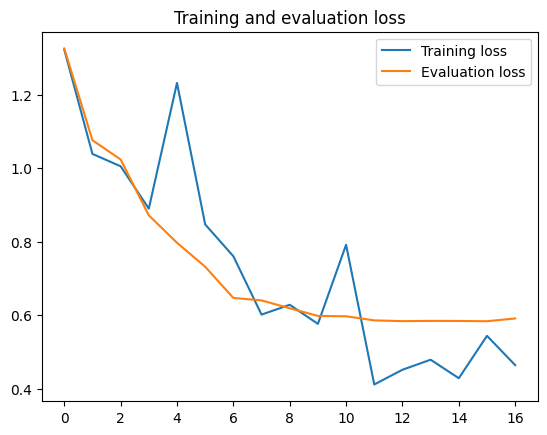

In [54]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [55]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

{'mcc': 0.6256329152713442, 'eval_loss': 0.5908143520355225}

In [56]:
predicted, probabilities = model.predict(test_df.text.to_list())
test_df['predicted'] = predicted

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Test set predictions

In [57]:
test_df.head(10)

,text,topic,predicted
0,I wouldn't be caught dead watching the NFL if ...,0,1
1,Chris O'Donnell stated that while filming for ...,1,1
2,"The whole game was a rollercoaster ride, but L...",0,0
3,"Zendaya slayed in Dune 2, as she does in all h...",1,1
4,While my favorite player was playing this matc...,0,0
5,My uncle's brother's neighbor's cat's veterina...,2,2
6,He said that The Great Gatsby is the best nove...,2,1
7,I could not look away from this train wrck of ...,1,1
8,The film Everything Everywhere All At Once fol...,1,1
9,I just finished reading pride and prejudice wh...,2,2


Evaluate the model's performance on the test set

In [58]:
# Result (note: your result can be different due to randomness in operations)
print(classification_report(test_df['topic'], test_df['predicted']))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         4
           2       1.00      0.67      0.80         3

    accuracy                           0.80        10
   macro avg       0.89      0.78      0.80        10
weighted avg       0.87      0.80      0.80        10



### End of this notebook.